In [1]:
import torch
from models.pyramid import build_pyramid_occupancy_network
from model import UNET
import torchvision.transforms as transforms
from dataset import NuScenesDataset
from torch.utils.data import DataLoader
import albumentations as A
import numpy as np
import cv2
from experiments.ipm.ipm_utilities import ipm_transform
import matplotlib.pyplot as plt
from configs.config_utilities import load_config

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [3]:
network = build_pyramid_occupancy_network()

with torch.no_grad():
    network.to(device)

/home/tunlaton11/miniconda3/envs/senior-project/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
model_path = "checkpoints/PON_multilabel_1684159649.6833959_00199.pt"

model_to_load = torch.load(model_path)
network.load_state_dict(model_to_load["model_state_dict"])

with torch.no_grad():
    network.eval()

In [5]:
config = load_config()


dataset = NuScenesDataset(
    nuscenes_dir="nuscenes",
    nuscenes_version="v1.0-mini",
    label_dir="labels",
    sample_tokens=config.val_tokens,
    image_size=(200, 112),
    # transform=transform
)

dataset_loader = DataLoader(
    dataset,
    batch_size=len(dataset),
    num_workers=2,
    pin_memory=True,
    shuffle=False,
)

--------------------------------------------------
Loading NuScenes version v1.0-mini ...
--------------------------------------------------


In [7]:
with torch.no_grad():
    for batch_idx, batch in enumerate(dataset_loader):
        image, label, mask, calib = batch

        image = image.to(device)

        label = label.to(device)
        mask = mask.to(device)
        calib = calib.to(device)
        pred = network(image, calib)


/home/tunlaton11/miniconda3/envs/senior-project/lib/python3.7/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/tunlaton11/miniconda3/envs/senior-project/lib/python3.7/site-packages/torch/nn/functional.py:4228: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [8]:
from logger import colorise
import matplotlib.pyplot as plt
from nuscenes_utilities import NUSCENES_CLASS_NAMES, flatten_labels
from torchmetrics import classification, Precision, Recall

In [78]:
iou_metric_by_class = classification.JaccardIndex(
    task="multilabel",
    num_classes=None,
    num_labels=14,
    average="none",
).to(device)


In [79]:
precision = Precision(
    task="multilabel",
    num_classes=None,
    num_labels=14,
    average="none",
).to(device)



In [80]:
recall = Recall(
    task="multilabel",
    num_classes=None,
    num_labels=14,
    average="none",
).to(device)


In [81]:
iou_result = iou_metric_by_class(pred, label)
precision_result = precision(pred, label)
recall_result = recall(pred, label)

In [91]:
for class_name, iou in zip(NUSCENES_CLASS_NAMES, iou_result):
    print(f"{class_name}, {iou*100:.4f}")

drivable_area, 75.8585
ped_crossing, 43.3793
walkway, 38.7887
carpark, 0.0000
car, 1.4964
truck, 3.2357
bus, 10.5002
trailer, 0.0000
construction_vehicle, 0.2375
pedestrian, 0.0000
motorcycle, 0.0000
bicycle, 0.0000
traffic_cone, 0.0000
barrier, 0.0000


In [92]:
for class_name, _precision, _recall in zip(NUSCENES_CLASS_NAMES, precision_result, recall_result):
    print(f"{class_name}, {_precision*100:.4f}, {_recall*100:.4f}")

drivable_area, 87.0518, 85.5064
ped_crossing, 63.0802, 58.1407
walkway, 57.0447, 54.7927
carpark, 0.0000, 0.0000
car, 8.6614, 1.7767
truck, 46.5409, 3.3606
bus, 18.4679, 19.5739
trailer, 0.0000, 0.0000
construction_vehicle, 8.0000, 0.2442
pedestrian, 0.0000, 0.0000
motorcycle, 0.0000, 0.0000
bicycle, 0.0000, 0.0000
traffic_cone, 0.0000, 0.0000
barrier, 0.0000, 0.0000


In [84]:
def plot_result_separate(pred: torch.Tensor, is_label:bool = True, title:str = None):
    fig, axs = plt.subplots(nrows=2, ncols=7, figsize=(20, 6))
    fig.suptitle(title, fontweight='bold', fontsize=18)
    axs = axs.flatten()

    if not is_label:
        pred = pred.sigmoid()

    for i, name in enumerate(NUSCENES_CLASS_NAMES):
        class_i = pred[i]
        axs[i].imshow(colorise(class_i, "coolwarm", 0, 1), origin='lower')
        axs[i].set_title(name)
        axs[i].axis('off')


In [85]:
def plot_result(
    img: torch.Tensor, label: torch.Tensor, mask: torch.Tensor, pred: torch.Tensor
):
    pred = (pred.sigmoid() >= 0.5).long().cpu()
    img = img.cpu().permute(1, 2, 0)
    label = label.cpu()
    mask = (mask.cpu() == -1).long()

    colorised_gt = colorise(
        flatten_labels(label),
        "nipy_spectral",
        flatten=True,
    ).permute(0, 2, 3, 1).squeeze(0)

    colorised_pred = colorise(
        flatten_labels(pred),
        "nipy_spectral",
        flatten=True,
    ).permute(0, 2, 3, 1).squeeze(0)

    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))
    axs[0].imshow(img)
    axs[0].set_title("Image")

    axs[1].imshow(colorised_gt, origin="lower")
    axs[1].set_title("Ground truth")

    axs[2].imshow(mask[..., None]*colorised_gt, origin="lower")
    axs[2].set_title("Ground truth + Visible mask")

    axs[3].imshow(colorised_pred, origin="lower")
    axs[3].set_title("Predicted")

    for ax in axs:
        ax.set_axis_off()

In [86]:
image_idx = 12

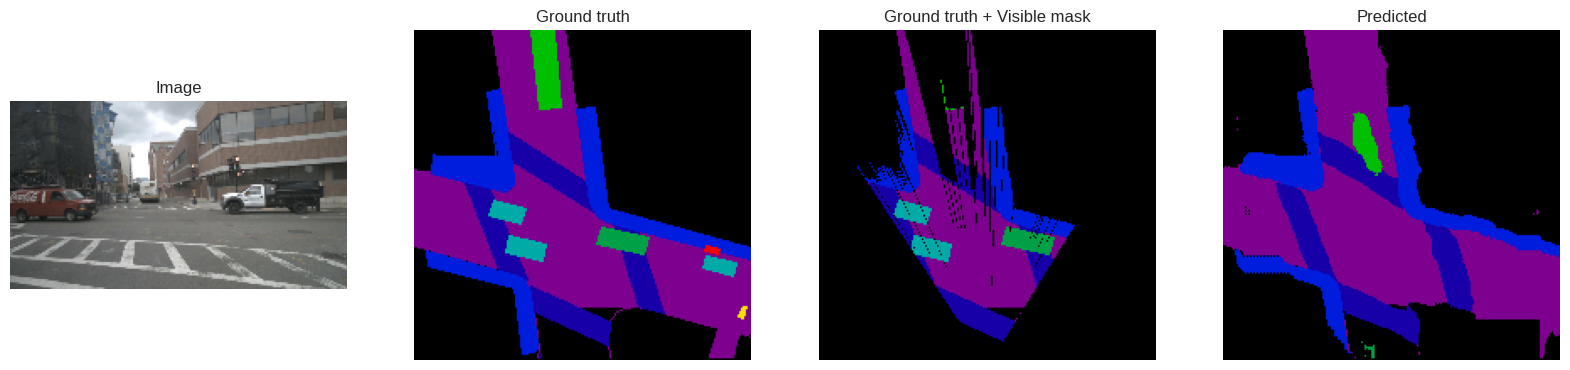

In [87]:
plot_result(image[image_idx], label[image_idx], mask[image_idx], pred[image_idx])

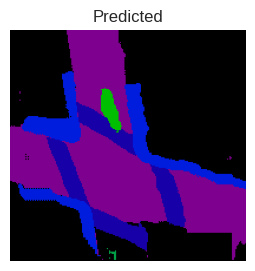

In [88]:
def plot_result_single(pred: torch.Tensor):
    pred = (pred.sigmoid() >= 0.5).long().cpu()

    colorised_pred = (
        colorise(
            flatten_labels(pred),
            "nipy_spectral",
            flatten=True,
        )
        .permute(0, 2, 3, 1)
        .squeeze(0)
    )

    plt.figure(figsize=(5, 3))

    plt.imshow(colorised_pred, origin="lower")
    plt.title("Predicted")
    plt.axis("off")


plot_result_single(pred[image_idx])

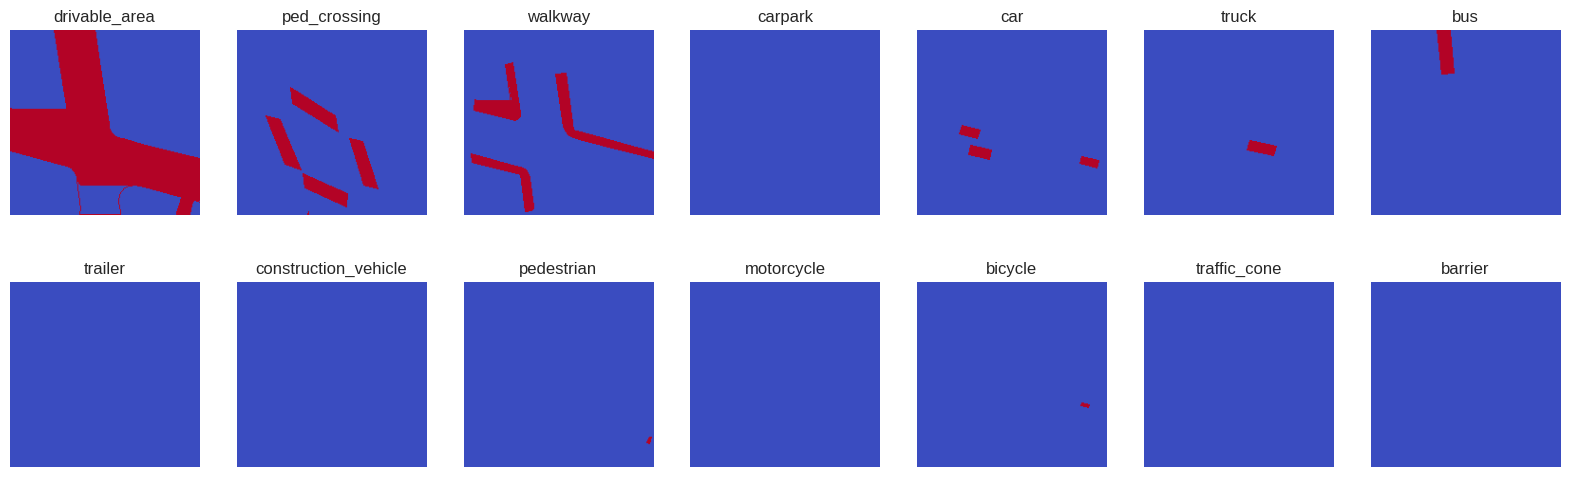

In [89]:
plot_result_separate(label[image_idx], is_label=True)

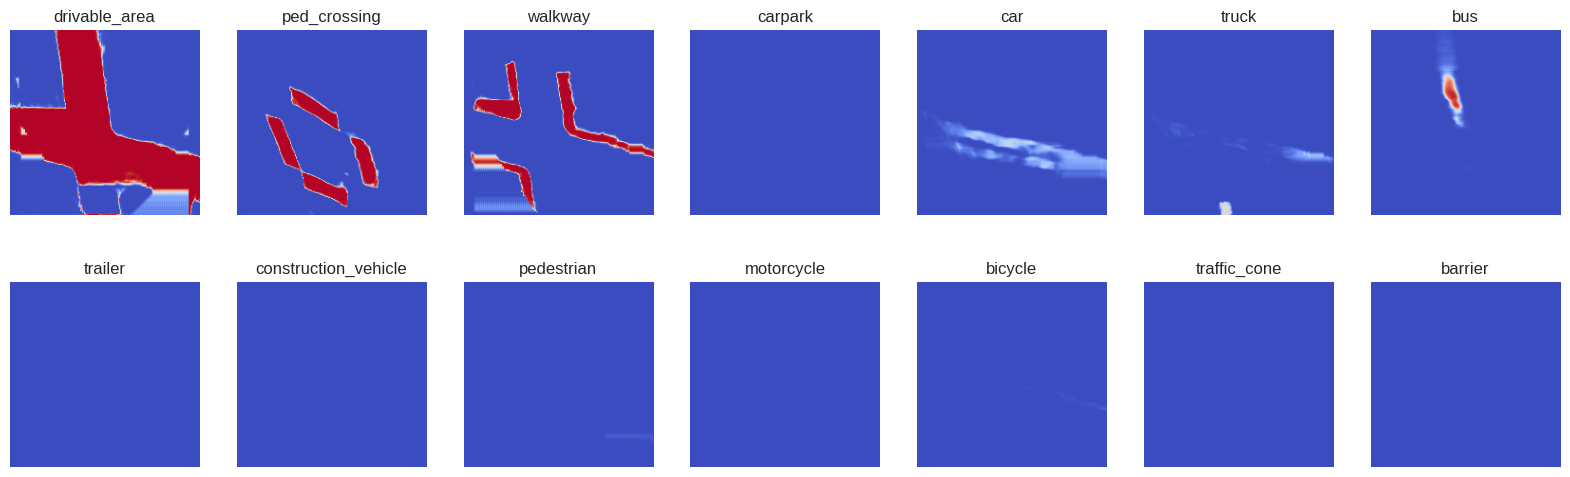

In [90]:
plot_result_separate(pred[image_idx], is_label=False)